In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import Imputer
from time import time

%matplotlib inline

In [3]:
train_raw = pd.read_csv("Data/train.csv")

In [4]:
print("There are {} rows and {} columns in given dataset".format(train_raw.shape[0],train_raw.shape[1]))

There are 595212 rows and 59 columns in given dataset


In [5]:
train_copy = train_raw

In [6]:
bin_features = []
cat_features = []
num_features = []
ordinal_features = []

    
for featr in train_copy.columns:
    if "bin" in featr or featr == 'target':
        bin_features.append(featr)
    elif "cat" in featr:
        cat_features.append(featr)
    elif train_copy[featr].dtype == float:
        num_features.append(featr)
    elif train_copy[featr].dtype == int:
        ordinal_features.append(featr)
    else:
        print("Couldn't store it anywhere")
    

        
print("There are {} number of binary features in train dataset".format(len(bin_features)))
print("There are {} number of categorical features in train dataset".format(len(cat_features)))
print("There are {} number of numerical features in train dataset".format(len(num_features)))
print("There are {} number of ordinal features in train dataset".format(len(ordinal_features)))

There are 18 number of binary features in train dataset
There are 14 number of categorical features in train dataset
There are 10 number of numerical features in train dataset
There are 17 number of ordinal features in train dataset


In [7]:
car_features = []
reg_features = []
ind_features = []
calc_features = []
remaining_features = []


for featr in train_copy.columns:
    if "car" in featr:
        car_features.append(featr)
    elif "reg" in featr:
        reg_features.append(featr)
    elif "ind" in featr:
        ind_features.append(featr)
    elif "calc" in featr:
        calc_features.append(featr)
    else:
        remaining_features.append(featr)

        
print("There are {} number of 'car' groupped features in train dataset".format(len(car_features)))
print("There are {} number of 'reg' groupped features in train dataset".format(len(reg_features)))
print("There are {} number of 'ind' groupped features in train dataset".format(len(ind_features)))
print("There are {} number of 'calc' groupped features in train dataset".format(len(calc_features)))
print("There are {} number of remaining features in train dataset".format(len(remaining_features)))

There are 16 number of 'car' groupped features in train dataset
There are 3 number of 'reg' groupped features in train dataset
There are 18 number of 'ind' groupped features in train dataset
There are 20 number of 'calc' groupped features in train dataset
There are 2 number of remaining features in train dataset


## Missing Value Analysis

In [8]:
train_raw.isnull().any().any()

False

In [9]:
## We see False above because the missing values has been replaced by -1 by default. 
## Let's replace -1 by NaN and treat the missing values correctly
train_copy = train_copy.replace(-1,np.NaN)

In [10]:
train_copy.isnull().any().any()

True

In [11]:
list_null_num = len(train_copy.index) - train_copy.count()
list_null_perc = ((len(train_copy.index) - train_copy.count()) / train_copy.shape[0]) * 100
list_null_num = list_null_num.sort_values(ascending=False)
list_null_perc = list_null_perc.sort_values(ascending=False)

missing_df = pd.DataFrame({'Missing Count':list_null_num,
                             'Missing Percentage(%)':list_null_perc})
missing_df.index.name = 'Feature Names'
missing_df.reset_index(inplace=True)

In [12]:
missing_df[missing_df['Missing Count'] > 0]

,Feature Names,Missing Count,Missing Percentage(%)
0,ps_car_03_cat,411231,69.089837
1,ps_car_05_cat,266551,44.782531
2,ps_reg_03,107772,18.106490
3,ps_car_14,42620,7.160474
4,ps_car_07_cat,11489,1.930237
5,ps_ind_05_cat,5809,0.975955
6,ps_car_09_cat,569,0.095596
7,ps_ind_02_cat,216,0.036290
8,ps_car_01_cat,107,0.017977
9,ps_ind_04_cat,83,0.013945


[<matplotlib.text.Text at 0x10dac55c0>, <matplotlib.text.Text at 0x1a25c11d30>]

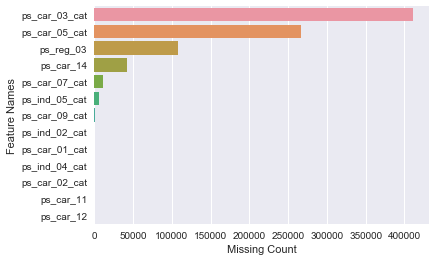

In [13]:
ax = sns.set(style="darkgrid", color_codes=True)
ax = sns.barplot(x= 'Missing Count', y='Feature Names',data=missing_df[missing_df['Missing Count']>0])
ax.set(xlabel = "Missing Count", ylabel = "Feature Names")

There are in total 13 variables out of 59 which has missing values. <br>
From the above table and the bar chart we have below observations - 
1. **ps_car_03_cat** (68%) and **ps_car_05_cat** (45%) columns has most number of missing values. We will be removing these two columns from our dataset as they won't contribute much towards predictions.
2. **ps_reg_03**, **ps_car_14** and **ps_car_12** are all continuos variable. We will replace the missing values by mean for these columns. 
3. **ps_car_11** has only 5 unique values which means it is a ordinal variable. We can replace the missing values with mode.
4. Rest all are categorical features with less 2% missing values. We can replace these missing values by mode of that columns. But let's develop the model and first with the missing values and see how the model perform. We can take a decision based on the model's performence

In [14]:
### Below code will imputer the missing values for few of the columns

## Initializing the imputer 
imp_mean = Imputer(missing_values= 'NaN', strategy= 'mean', axis= 0)
imp_most_frequent = Imputer(missing_values= 'NaN', strategy= 'most_frequent', axis= 0)

## Fit and transform the data using the Imputers above
train_copy['ps_reg_03'] = imp_mean.fit_transform(train_copy[['ps_reg_03']])
train_copy['ps_car_14'] = imp_mean.fit_transform(train_copy[['ps_car_14']])
train_copy['ps_car_12'] = imp_mean.fit_transform(train_copy[['ps_car_12']])

train_copy['ps_car_11'] = (imp_most_frequent.fit_transform(train_copy[['ps_car_11']])).astype(int)
train_copy['ps_car_07_cat'] = (imp_most_frequent.fit_transform(train_copy[['ps_car_07_cat']])).astype(int)
train_copy['ps_ind_05_cat'] = (imp_most_frequent.fit_transform(train_copy[['ps_ind_05_cat']])).astype(int)
train_copy['ps_car_09_cat'] = (imp_most_frequent.fit_transform(train_copy[['ps_car_09_cat']])).astype(int)
train_copy['ps_ind_02_cat'] = (imp_most_frequent.fit_transform(train_copy[['ps_ind_02_cat']])).astype(int)
train_copy['ps_car_01_cat'] = (imp_most_frequent.fit_transform(train_copy[['ps_car_01_cat']])).astype(int)
train_copy['ps_ind_04_cat'] = (imp_most_frequent.fit_transform(train_copy[['ps_ind_04_cat']])).astype(int)
train_copy['ps_car_02_cat'] = (imp_most_frequent.fit_transform(train_copy[['ps_car_02_cat']])).astype(int)


### Let's drop the 2 features with mostly missing values in them

train_copy.drop(['ps_car_03_cat','ps_car_05_cat'],axis=1,inplace=True)

## Remove these features from our categorical feature list as well. 

cat_features.remove('ps_car_03_cat')
cat_features.remove('ps_car_05_cat')

In [15]:
# from fancyimpute import SoftImpute

# train_copy['ps_car_02_cat']= pd.DataFrame(SoftImpute().complete(train_copy.as_matrix(columns=['ps_car_02_cat']))) 
# train_copy['ps_car_07_cat']= pd.DataFrame(SoftImpute().complete(train_copy.as_matrix(columns=['ps_car_07_cat']))) 
# train_copy['ps_ind_05_cat']= pd.DataFrame(SoftImpute().complete(train_copy.as_matrix(columns=['ps_ind_05_cat']))) 
# train_copy['ps_car_09_cat']= pd.DataFrame(SoftImpute().complete(train_copy.as_matrix(columns=['ps_car_09_cat']))) 
# train_copy['ps_ind_02_cat']= pd.DataFrame(SoftImpute().complete(train_copy.as_matrix(columns=['ps_ind_02_cat']))) 
# train_copy['ps_car_01_cat']= pd.DataFrame(SoftImpute().complete(train_copy.as_matrix(columns=['ps_car_01_cat']))) 
# train_copy['ps_ind_04_cat']= pd.DataFrame(SoftImpute().complete(train_copy.as_matrix(columns=['ps_ind_04_cat']))) 

In [16]:
print("After this initial data preprocessing, now we have {} number of rows and {} number of features".format(train_copy.shape[0],train_copy.shape[1]))

After this initial data preprocessing, now we have 595212 number of rows and 57 number of features


In [17]:
train_copy.head(10)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0
5,19,0,5,1,4,0,0,0,0,0,...,4,2,0,9,0,1,0,1,1,1
6,20,0,2,1,3,1,0,0,1,0,...,3,0,0,10,0,1,0,0,1,0
7,22,0,5,1,4,0,0,1,0,0,...,7,1,3,6,1,0,1,0,1,0
8,26,0,5,1,3,1,0,0,0,1,...,4,2,1,5,0,1,0,0,0,1
9,28,1,1,1,2,0,0,0,1,0,...,3,5,0,6,0,1,0,0,1,0


In [18]:
train_float = train_copy.select_dtypes(include=['float64'])
train_int = train_copy.select_dtypes(include=['int64'])
Counter(train_copy.dtypes.values)

Counter({dtype('int64'): 47, dtype('float64'): 10})

In [19]:
cat_features

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_04_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

## Correlation Plot

In [20]:
# train_copy_sub = train_copy.drop(['target'],axis=1)

# ## Correlstion plot for all float Features
# ax = plt.figure(figsize=(16,16))
# ax = sns.heatmap(train_copy_sub.corr(),linewidths=0.01,vmax=1.0, square=True, linecolor='black', cmap=plt.cm.jet)
# ax.set_title("Correlation Plot for All Features")
# plt.show()
# plt.close()

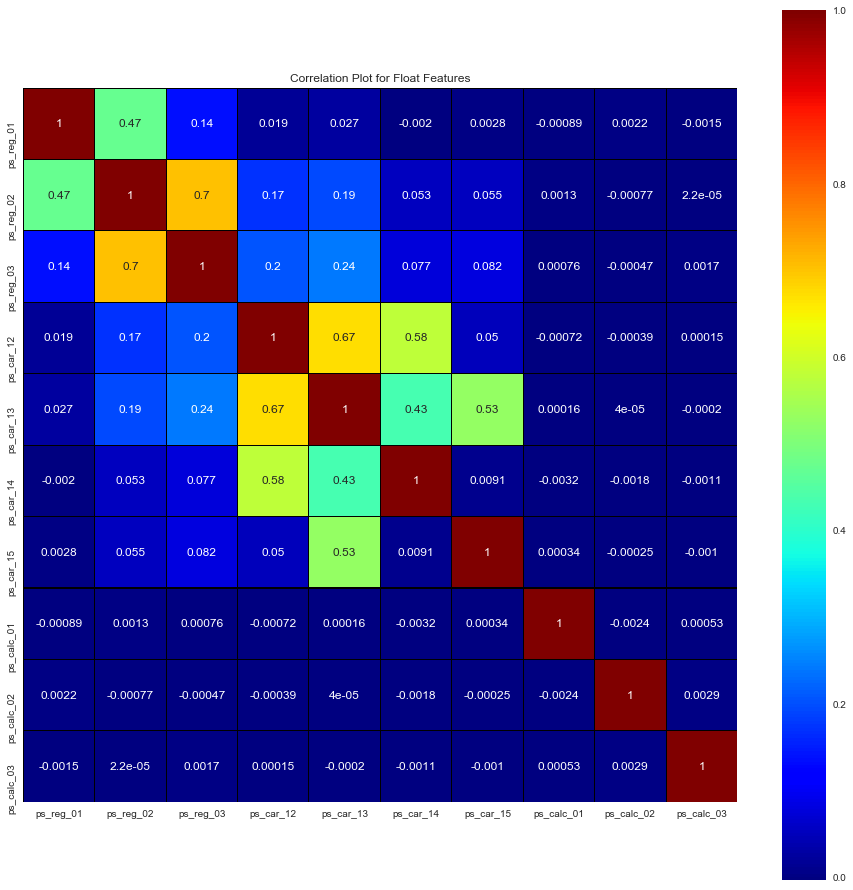

In [21]:
## Correlstion plot for all float Features
ax = plt.figure(figsize=(16,16))
ax = sns.heatmap(train_float.corr(),linewidths=0.01,vmax=1.0, square=True, linecolor='black', cmap=plt.cm.jet, annot= True)
ax.set_title("Correlation Plot for Float Features")
plt.show()
plt.close()

From the above correlation plot we have following observations - 
 1. ps_reg_02 is highly correlated to ps_reg_01 and ps_reg_03
 2. ps_car_13 is highly correlated to ps_car_12,ps_car_14 and ps_car_15
 3. ps_car_14 is corrleated to ps_car_12
<br>
As you can see ps_calc_01 - ps_calc_03 are not correlated to any of the other features. We can remove these uncorrelated features from analysis. 

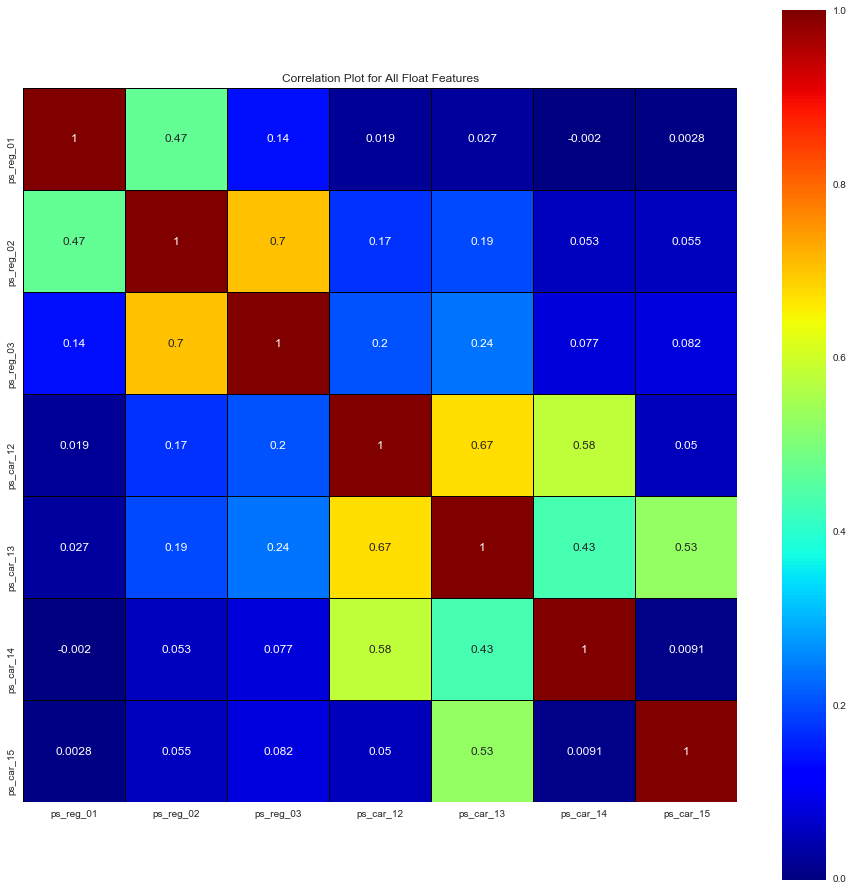

In [22]:
train_float_sub = train_float.drop(['ps_calc_03', 'ps_calc_02', 'ps_calc_01'], axis=1)

## Correlstion plot for all float Features
ax = plt.figure(figsize=(16,16))
ax = sns.heatmap(train_float_sub.corr(),linewidths=0.01,vmax=1.0, square=True, linecolor='black', cmap=plt.cm.jet, annot= True)
ax.set_title("Correlation Plot for All Float Features")
plt.show()
plt.close()

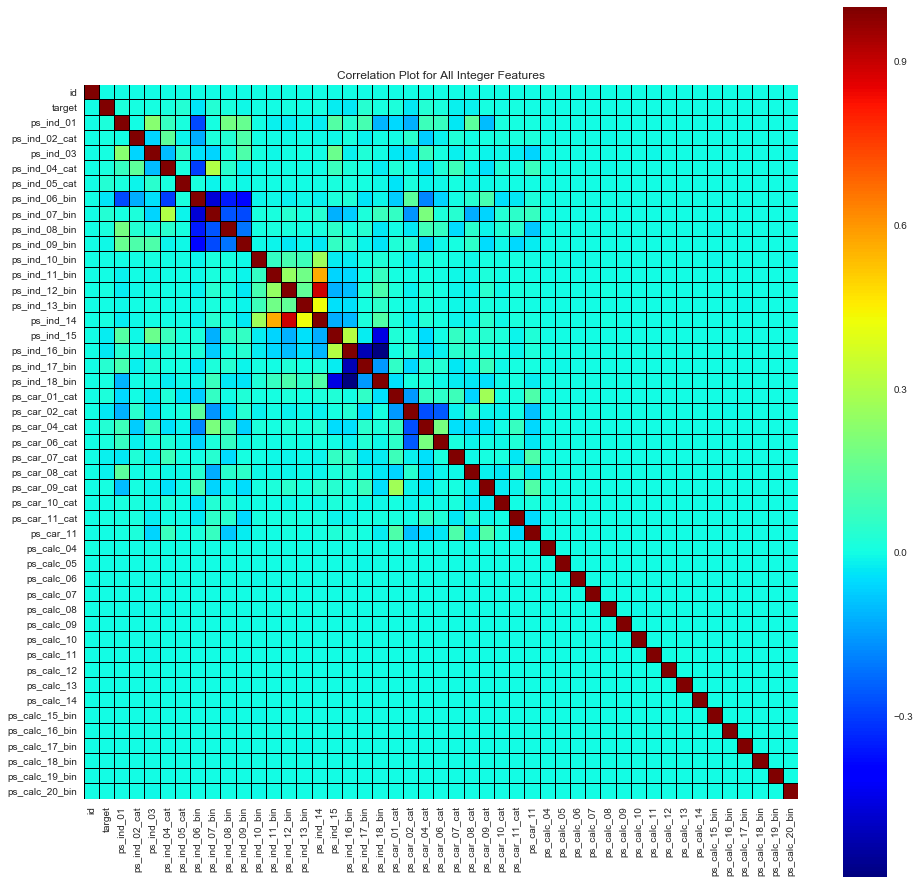

In [23]:
## Correlstion plot for all integer Features

ax = plt.figure(figsize=(16,16))
ax = sns.heatmap(train_int.corr(),linewidths=0.01,vmax=1.0, square=True, linecolor='black', cmap=plt.cm.jet)
ax.set_title("Correlation Plot for All Integer Features")
plt.show()
plt.close()

From the correlation plot of integer features in our dataset, we can see that Features ps_calc_04 till ps_calc_20_bin are not correlated (either positive or negative) to any of the other features in the data. So we will go ahead and remove these features from our analysis for now.

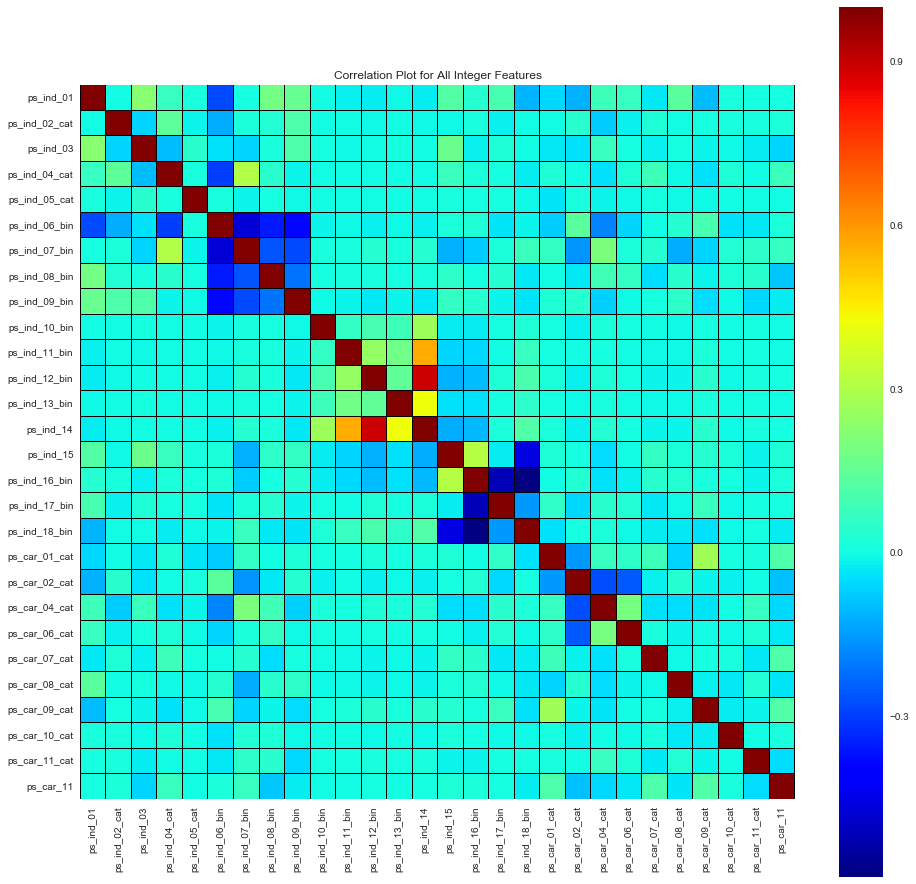

In [24]:
to_drop_int = ['id','target', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 
                'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin', 
                'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']
train_int_sub = train_int.drop(to_drop_int,axis=1)

ax = plt.figure(figsize=(16,16))
ax = sns.heatmap(train_int_sub.corr(),linewidths=0.01,vmax=1.0, square=True, linecolor='black', cmap=plt.cm.jet)
ax.set_title("Correlation Plot for All Integer Features")
plt.show()
plt.close()

For 11 out of 12 categorical features we have less than 20 unique values, so we can create dummy variables for these categorical values <br>

## Explore Target Variable 

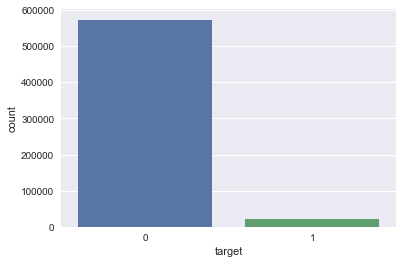

In [25]:
ax = sns.set(style="darkgrid", color_codes=True)
ax = sns.countplot(train_copy['target'])

As we can see in the plot above very few claims were filed.

## Explore Categorical Variable

### Checking cardinality of Categorical feature

In [26]:
for featr in cat_features:
    print("Variable {} has {} unique values".format(featr,train_copy[featr].value_counts().shape[0]))

Variable ps_ind_02_cat has 4 unique values
Variable ps_ind_04_cat has 2 unique values
Variable ps_ind_05_cat has 7 unique values
Variable ps_car_01_cat has 12 unique values
Variable ps_car_02_cat has 2 unique values
Variable ps_car_04_cat has 10 unique values
Variable ps_car_06_cat has 18 unique values
Variable ps_car_07_cat has 2 unique values
Variable ps_car_08_cat has 2 unique values
Variable ps_car_09_cat has 5 unique values
Variable ps_car_10_cat has 3 unique values
Variable ps_car_11_cat has 104 unique values


In [27]:
cat_features_temp =  list(cat_features)
cat_features_temp.remove('ps_car_11_cat')
cat_features_temp

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_04_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat']

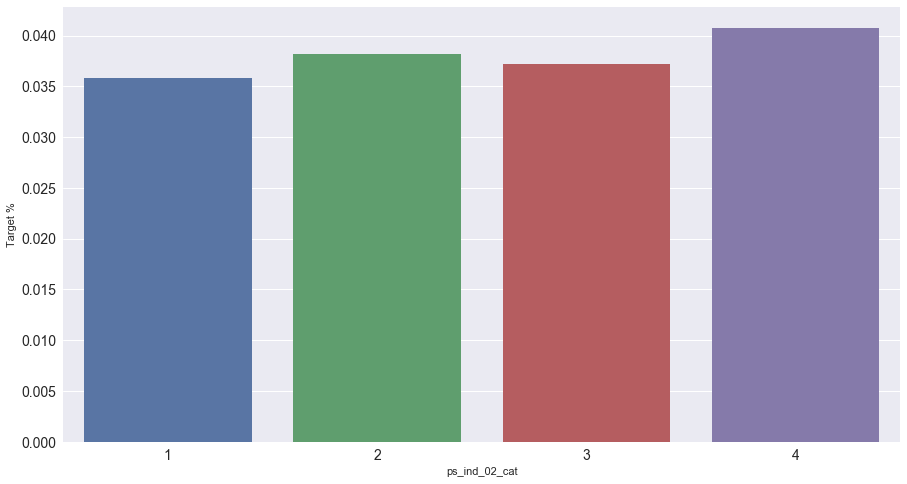

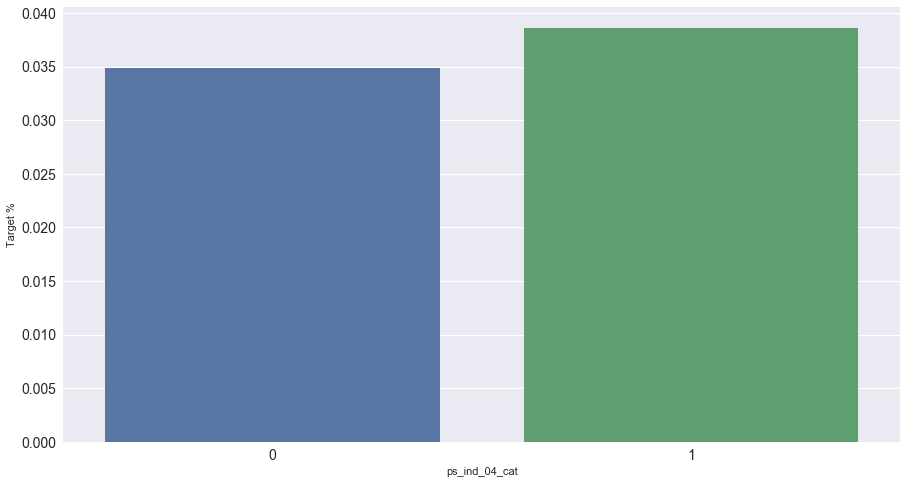

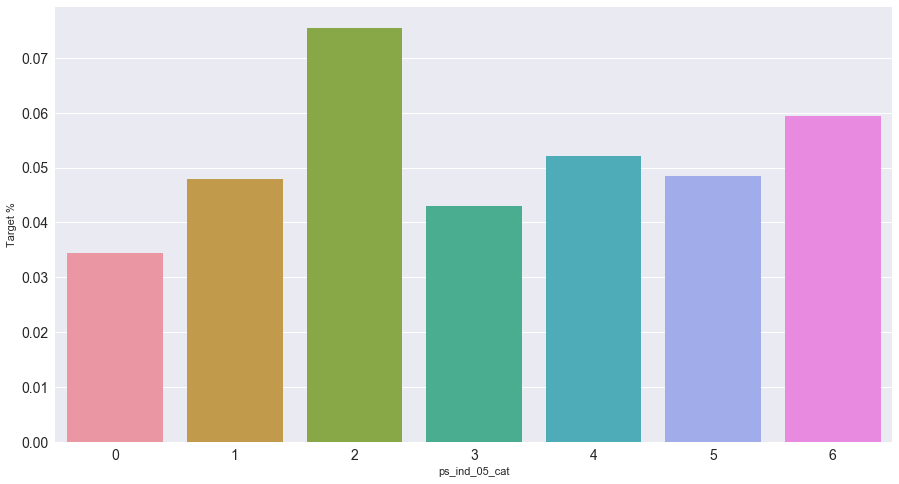

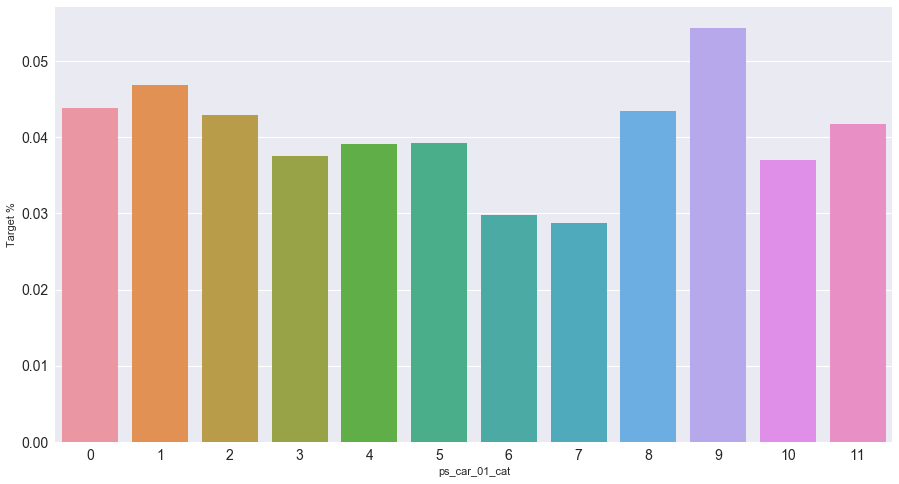

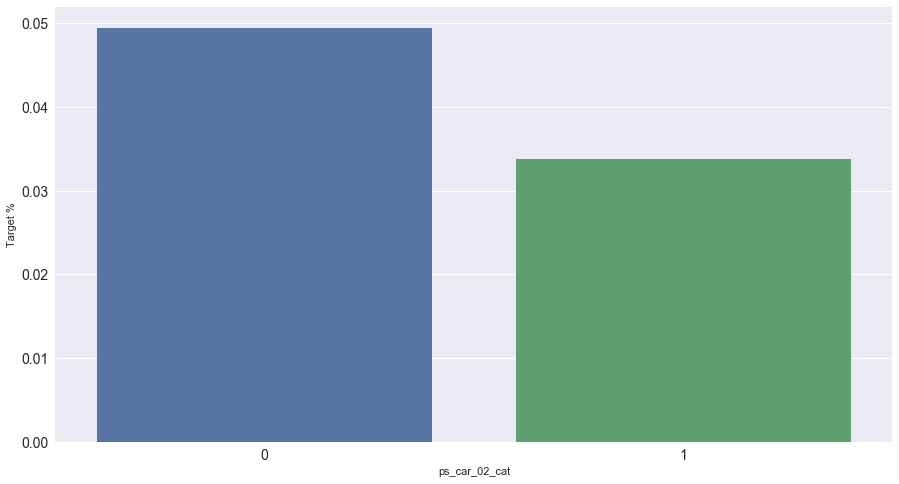

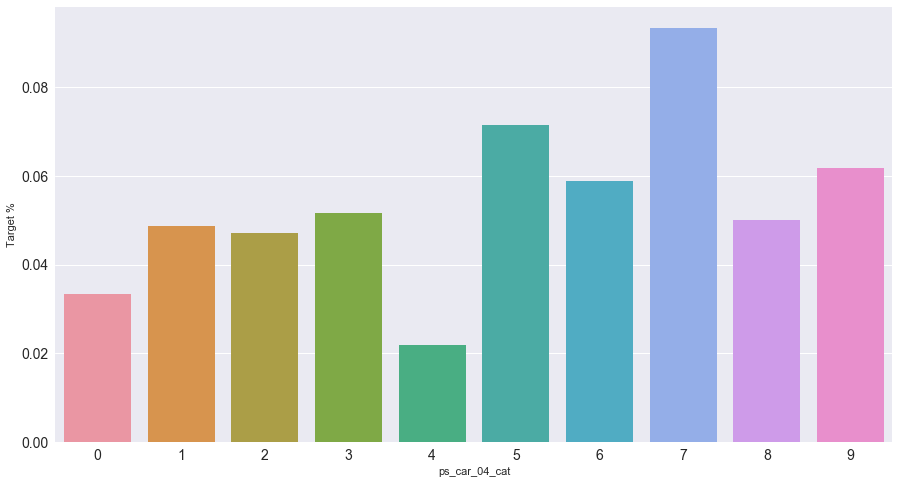

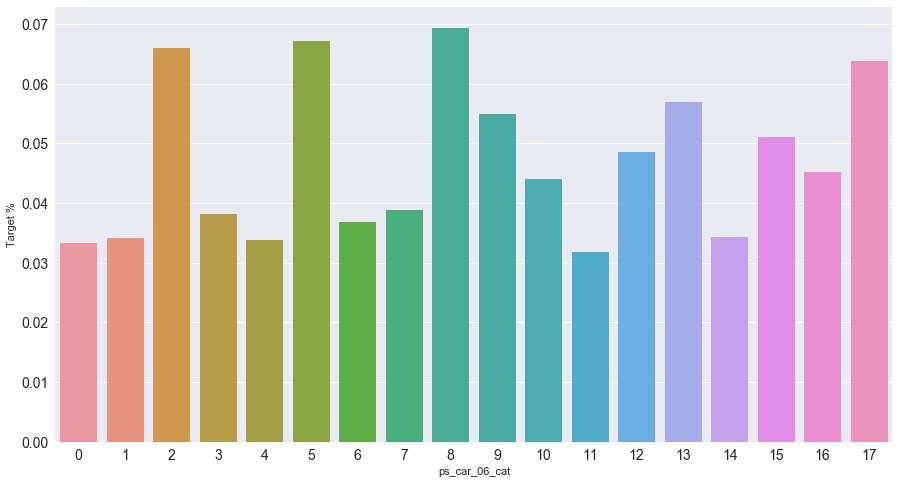

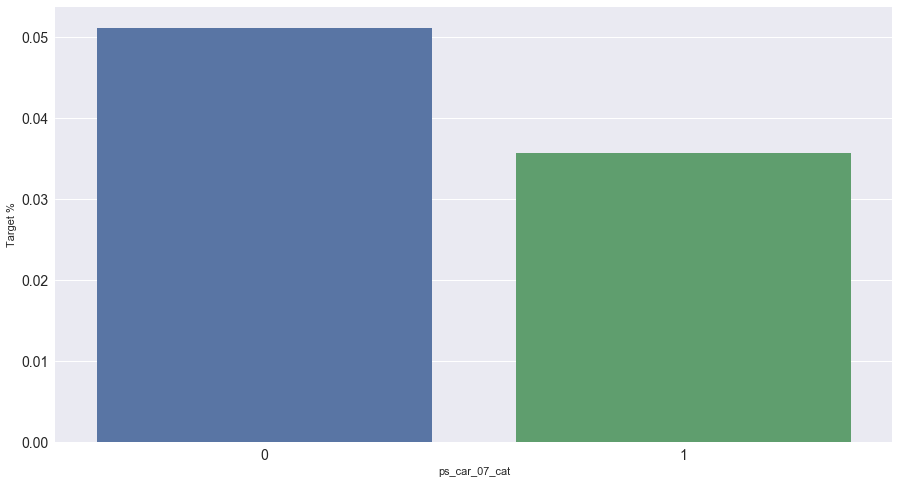

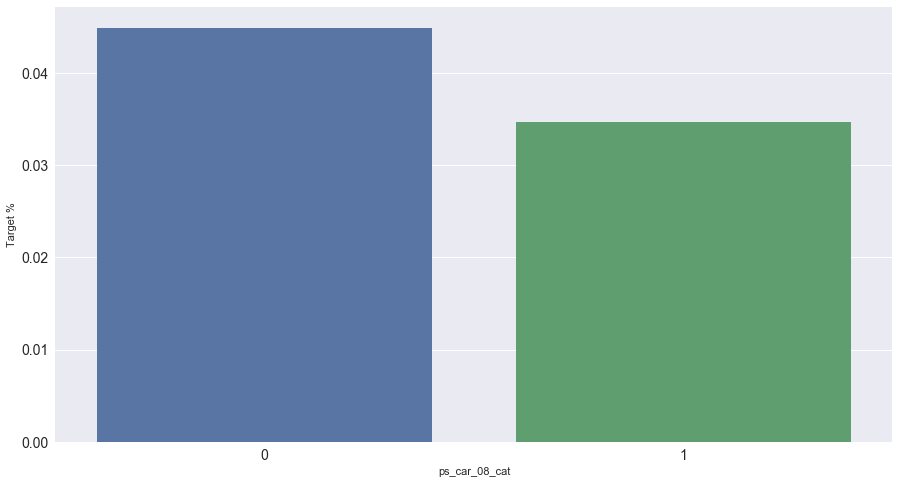

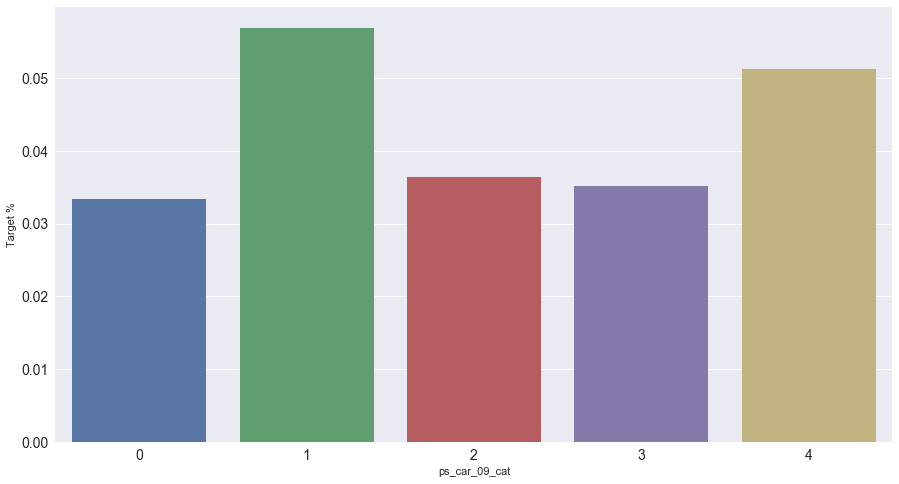

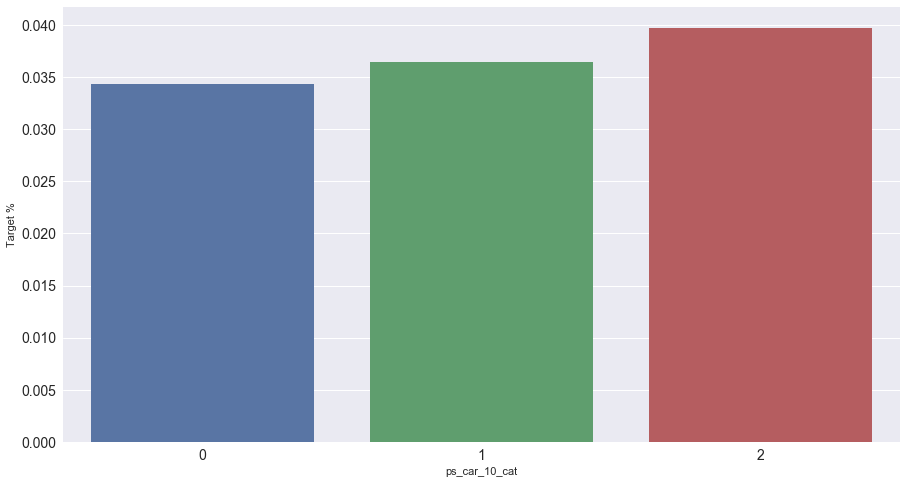

In [28]:
for cat_featr in cat_features_temp:
    plt.figure()
    fig= plt.subplots(figsize=(15,8))
    temp_data = train_copy[[cat_featr,'target']].groupby(cat_featr,as_index = False).mean().sort_values('target')
    sns.barplot(x=cat_featr,y='target',data=temp_data)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.ylabel("Target %")
    plt.show()
    plt.close()

From the above analysis we can see that there are couple of categorical variables which actually are binary variables.
We will move these 4 features from Categorical list to Binary feature list

In [29]:
features_to_move = ['ps_ind_04_cat','ps_car_02_cat','ps_car_07_cat','ps_car_08_cat']

In [30]:
cat_features = [x for x in cat_features if x not in features_to_move]

In [31]:
bin_features.append('ps_ind_04_cat')
bin_features.append('ps_car_02_cat')
bin_features.append('ps_car_07_cat')
bin_features.append('ps_car_08_cat')

## Explore Binary Variable

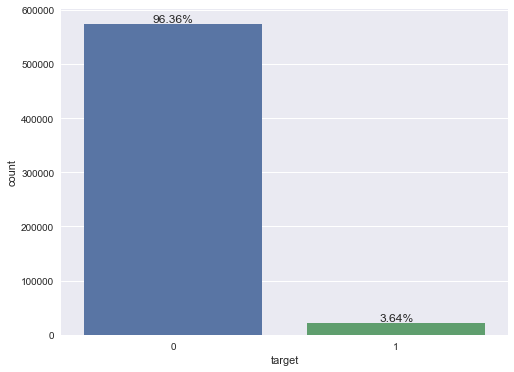

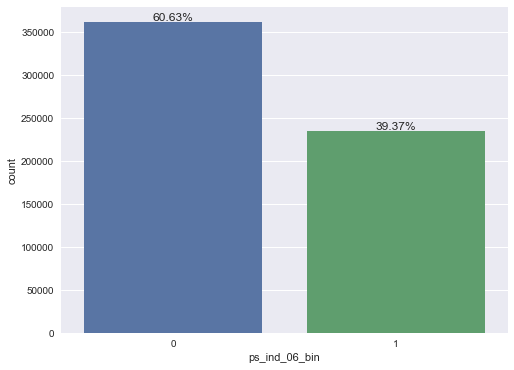

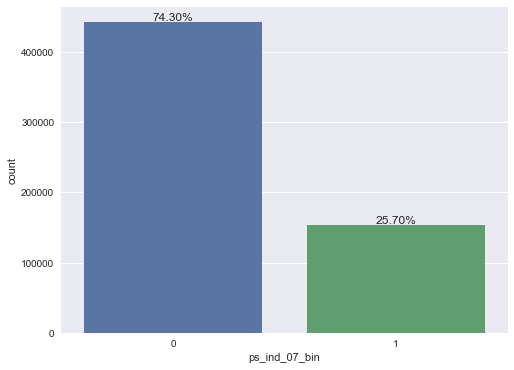

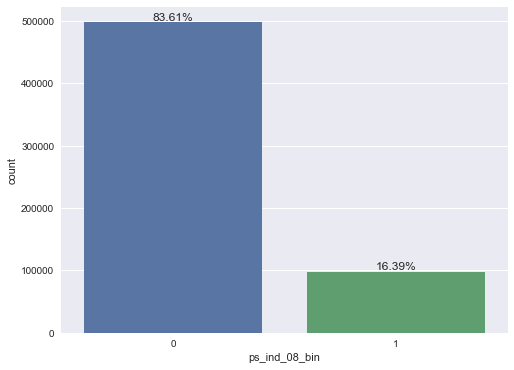

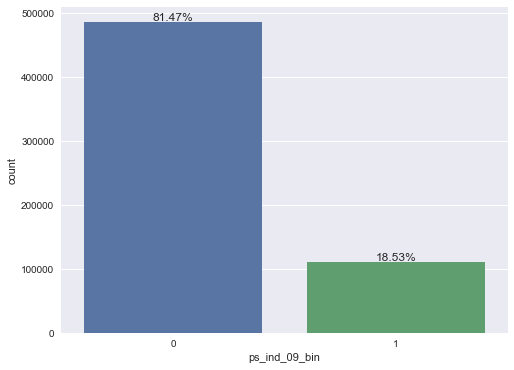

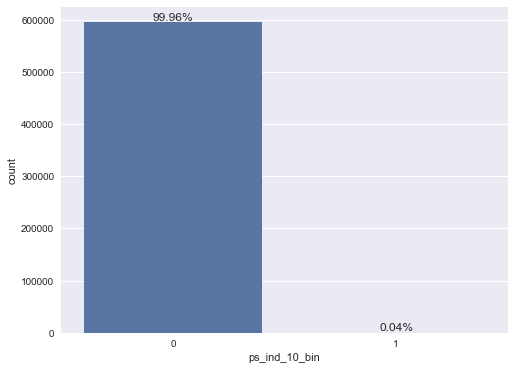

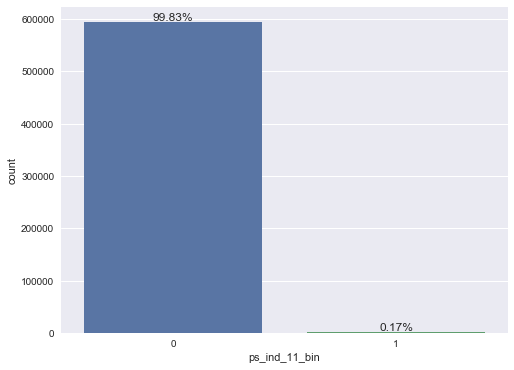

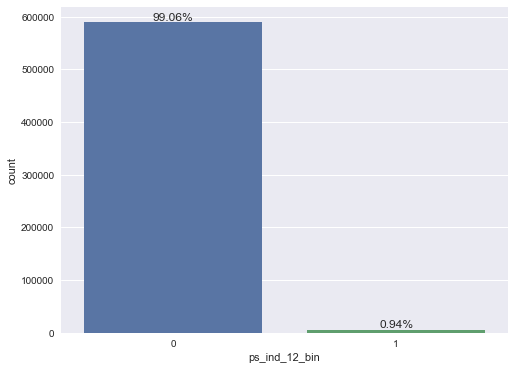

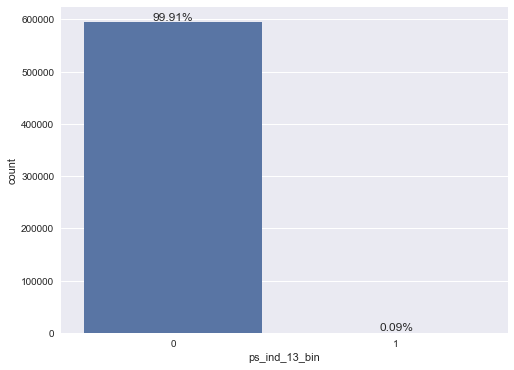

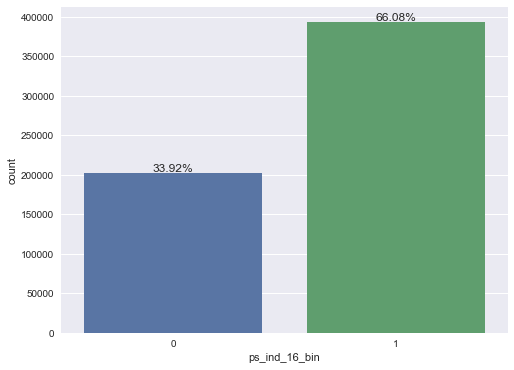

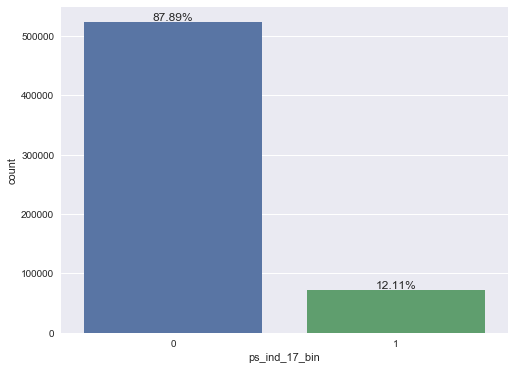

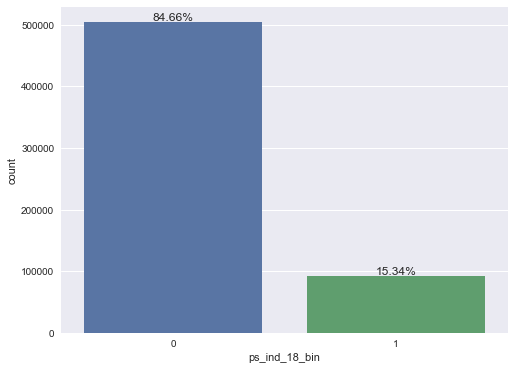

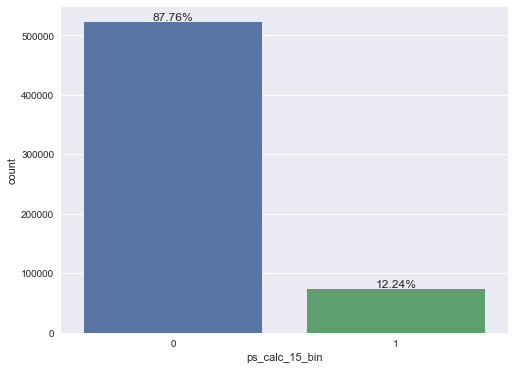

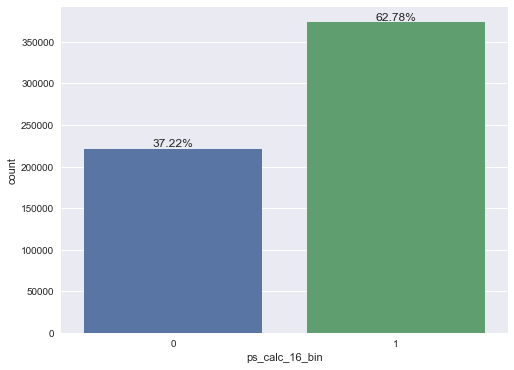

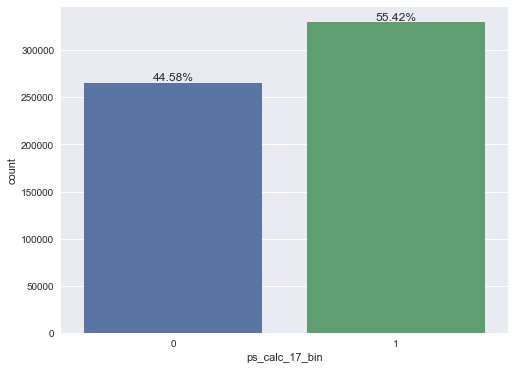

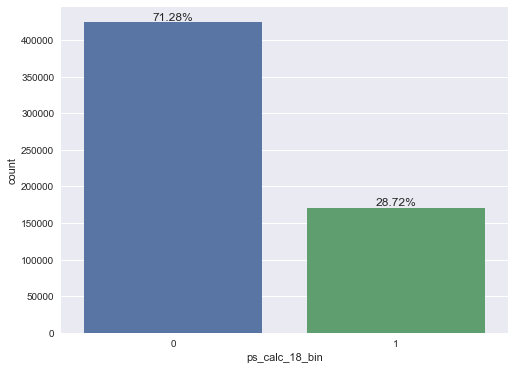

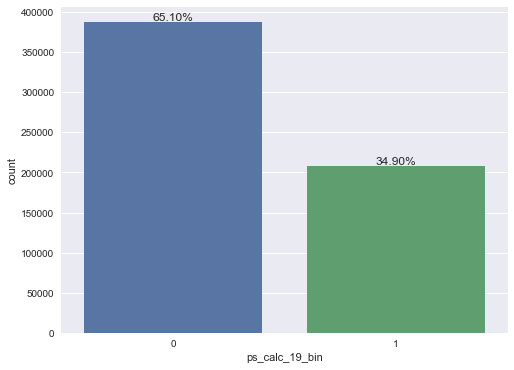

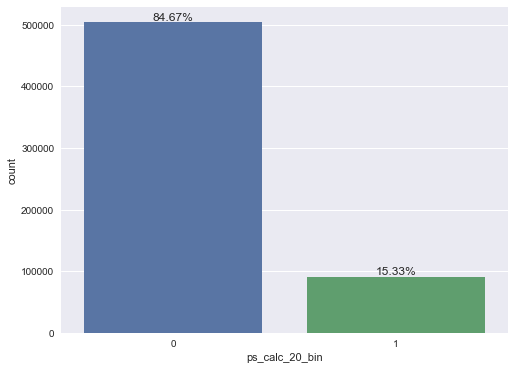

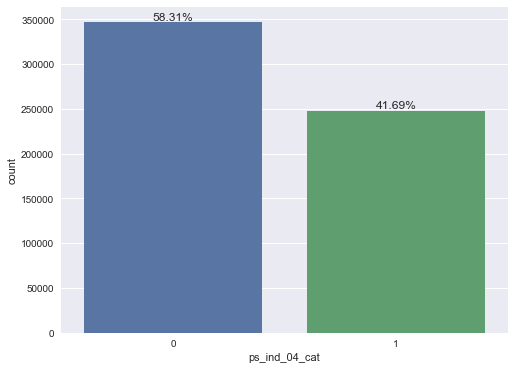

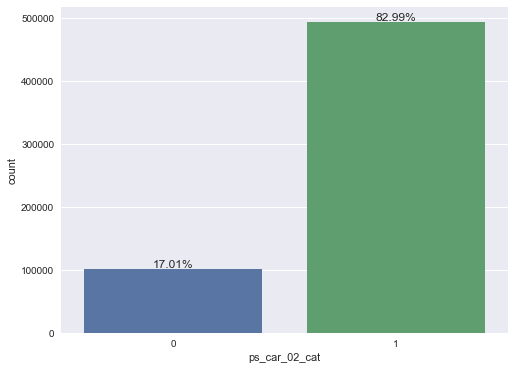

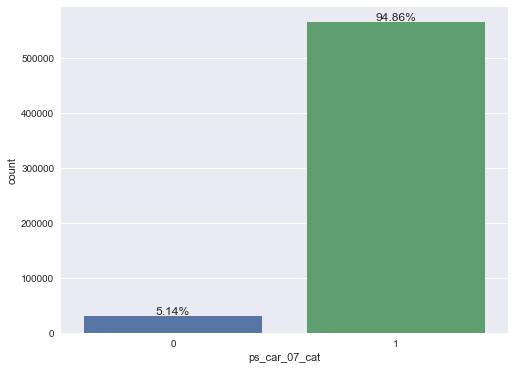

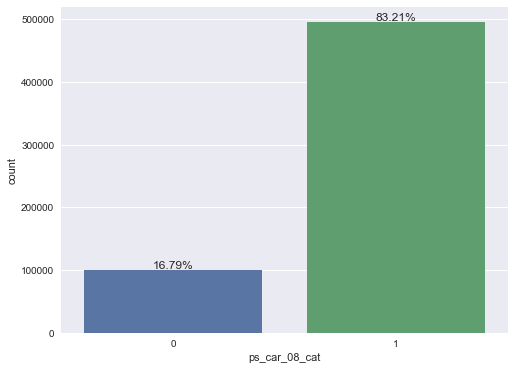

In [32]:
for bin_featr in bin_features:
    plt.figure()
    fig= plt.subplots(figsize=(8,6))
    sns.set(style="darkgrid")
    ax = sns.countplot(x=bin_featr, data= train_copy)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format((height/(float(len(train_copy))))*100),
                ha="center",va="bottom") 
    plt.show()
    plt.close()

We can see from above analysis that ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin and ps_ind_13_bin have only one value (1). We will remove these columns from our analysis as they won't controbute much towards prdictive model. 

In [33]:
## Dropiing the columns those we discussed above

train_copy = train_copy.drop(['ps_ind_10_bin','ps_ind_11_bin','ps_ind_12_bin','ps_ind_13_bin'],axis=1)

## Removing these features from the feature list of binary variables

bin_features = [x for x in bin_features if x not in ['ps_ind_10_bin','ps_ind_11_bin','ps_ind_12_bin','ps_ind_13_bin']]

In [34]:
print("New Shape of Training data is {}".format(train_copy.shape))

New Shape of Training data is (595212, 53)


## Feature Encoding

Only ps_car_11_cat has many distinct values. To avoid having many dummy variables later on and introducing the curse of dimensionality, we could replace the values in this variable by the supervised ratio. Other strategies to transform this variable are explained in an [article on KDNuggets](http://www.kdnuggets.com/2016/08/include-high-cardinality-attributes-predictive-model.html). We will replace the column with ps_car_11_cat_tm (target mean)

In [35]:
cat_perc = train_copy[['ps_car_11_cat', 'target']].groupby(['ps_car_11_cat'],as_index=False).mean()
cat_perc.rename(columns={'target': 'ps_car_11_cat_tm'}, inplace=True)
train_copy = pd.merge(train_copy, cat_perc, how='inner', on='ps_car_11_cat')
train_copy.drop('ps_car_11_cat', axis=1, inplace=True)

In [36]:
## Removing it from the categorical feature names list
cat_features.remove('ps_car_11_cat')
num_features.append('ps_car_11_cat_tm')

In [37]:
print("There are {} number of binary features in train dataset".format(len(bin_features)))
print("There are {} number of categorical features in train dataset".format(len(cat_features)))
print("There are {} number of numerical features in train dataset".format(len(num_features)))
print("There are {} number of ordinal features in train dataset".format(len(ordinal_features)))

There are 18 number of binary features in train dataset
There are 7 number of categorical features in train dataset
There are 11 number of numerical features in train dataset
There are 17 number of ordinal features in train dataset


### Seperate Data into Feature and Target

In [38]:
## Split the data into features and target label

train_target = train_copy['target']
to_drop = ['target','id']
train_features = train_copy.drop(to_drop, axis=1,inplace=False)

### Normalizing Numerical Features

In [39]:
## Normalizing num features
## Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_features[num_features] = scaler.fit_transform(train_features[num_features])

In [40]:
train_features[num_features].head(5)

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_car_11_cat_tm
0,0.777778,0.111111,0.165170,0.25753,0.182438,0.495899,0.963624,0.666667,0.555556,0.222222,0.356673
1,0.666667,0.222222,0.162302,0.25753,0.206802,0.408584,1.000000,0.666667,0.555556,0.777778,0.356673
2,1.000000,0.111111,0.141389,0.25753,0.178848,0.495899,0.963624,1.000000,0.000000,0.666667,0.356673
3,1.000000,0.111111,0.137690,0.25753,0.151017,0.495899,0.925820,0.222222,0.666667,0.333333,0.356673
4,0.444444,0.000000,0.141640,0.25753,0.189679,0.495899,1.000000,0.444444,0.000000,0.666667,0.356673


### Encoding Categorical Features

In [41]:
## As we have all the nuerical values in our categorical columns, we are going to create a function which replaces..
## .. the column names with appropriate names containing some part of original column name
def one_hot_encode(df,cat_features_list):
    
    for each_featr in cat_features_list:
        oneHotEncode_temp = pd.get_dummies(df[each_featr])
        new_col_names = ["{}_{}".format(each_featr,x) for x in oneHotEncode_temp.columns]
        oneHotEncode_temp.columns = new_col_names
        df = df.drop(each_featr, axis = 1)
        df = pd.concat([df,oneHotEncode_temp],axis = 1)
    return df
    

In [42]:
train_features_encoded = one_hot_encode(train_features,cat_features)

In [43]:
print("There are {} rows and {} columns in final encoded dataset".format(train_features_encoded.shape[0],train_features_encoded.shape[1]))

There are 595212 rows and 103 columns in final encoded dataset


## Feature Selection

In [44]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

lsvc = LinearSVC(C=0.1, penalty="l1", dual=False).fit(train_features_encoded, train_target)
model = SelectFromModel(lsvc, prefit=True)

train_features_encoded_sel = model.transform(train_features_encoded)


In [45]:
print("There are {} rows and {} columns are there after feature selection.".format(train_features_encoded_sel.shape[0],train_features_encoded_sel.shape[1]))

There are 595212 rows and 90 columns are there after feature selection.


In [46]:
# # TODO: Import a supervised learning model that has 'feature_importances_'
# from sklearn.ensemble import RandomForestClassifier

# # TODO: Train the supervised model on the training set 
# model = RandomForestClassifier(n_estimators=10,random_state = 32)
# model.fit(X_train,y_train)


# # TODO: Extract the feature importances
# importances = model.feature_importances_

In [47]:
# feats = {} # a dict to hold feature_name: feature_importance
# for feature, importance in zip(train_features_encoded.columns, model.feature_importances_):
#     feats[feature] = importance #add the name/value pair 

# importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'feature_importance'})
# importances.sort_values(by='feature_importance',ascending=False,inplace=True)
# importances.index.name = 'Feature_name'
# importances.reset_index(inplace=True)

In [48]:
# ax = plt.subplots(figsize=(6, 20))
# sns.set_style("whitegrid")
# ax = sns.barplot(x="feature_importance",y="Feature_name",data=importances, color='b')
# ax.set_xlabel('Feature Importance')
# ax.set_ylabel('Feature Name')
# ax.set_title('Feature Importance for Predictive Features')

# x = list(importances['feature_importance'])
# myFormattedList = [ '%.4f' % elem for elem in x ]
# reacts = ax.patches

# for re,label in zip(reacts,myFormattedList):
#     width = re.get_width()
#     ax.text(width+0.004,re.get_y(),str(label),ha="center", va="top",fontsize = 8,fontweight='bold',color = 'blue')
# plt.show()
# plt.close()

### Shuffle and Split

In [49]:

# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_features_encoded, train_target, test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} rows and {} columns.".format(X_train.shape[0],X_train.shape[1]))
print("Testing set has {} samples and {} columns.".format(X_test.shape[0],X_test.shape[1]))

/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Training set has 476169 rows and 103 columns.
Testing set has 119043 samples and 103 columns.


## Model Selection

#### Implementation - Creating a Training and Predicting Pipeline<br>

To properly evaluate the performance of each model we've chosen, it's important that we create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. 


In [75]:

# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
     
    # Cross Validation score    
    results['cv_auc_score'] = cross_val_score(learner, X_train[:sample_size],y_train[:sample_size], cv=5,scoring='roc_auc').mean()   
    
#     # TODO: Compute accuracy on the first 300 training samples
#     results['acc_train'] = accuracy_score(y_train,predictions_train)
        
#     # TODO: Compute accuracy on test set
#     results['acc_test'] = accuracy_score(y_test,predictions_test)
    
#     # TODO: Compute F-score on the the first 300 training samples
#     results['f_train'] = fbeta_score(y_train,predictions_train, beta = 0.5)
        
#     # TODO: Compute F-score on the test set
#     results['f_test'] = fbeta_score(y_test,predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [76]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

# TODO: Initialize the three models
clf_A = XGBClassifier(random_state = 32)
clf_B = SGDClassifier(random_state = 32)
clf_C = GaussianNB()
clf_D = GradientBoostingClassifier(random_state=32)


# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(len(X_train) * 0.01)
samples_10 = int(len(X_train) * 0.1)
samples_100 =int(len(X_train) * 1)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)



/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


XGBClassifier trained on 4761 samples.
XGBClassifier trained on 47616 samples.
XGBClassifier trained on 476169 samples.
SGDClassifier trained on 4761 samples.
SGDClassifier trained on 47616 samples.
SGDClassifier trained on 476169 samples.
GaussianNB trained on 4761 samples.
GaussianNB trained on 47616 samples.
GaussianNB trained on 476169 samples.
GradientBoostingClassifier trained on 4761 samples.
GradientBoostingClassifier trained on 47616 samples.
GradientBoostingClassifier trained on 476169 samples.


In [77]:
for i in results.items():
    print(i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

XGBClassifier


,1%,10%,100%
cv_auc_score,0.551445,0.627122,0.635582
pred_time,0.924123,0.513838,0.758065
train_time,1.707635,16.561517,186.849610


SGDClassifier


,1%,10%,100%
cv_auc_score,0.565616,0.574240,0.570512
pred_time,0.065441,0.049910,0.066282
train_time,0.012629,0.148556,1.714775


GaussianNB


,1%,10%,100%
cv_auc_score,0.489365,0.595666,0.605061
pred_time,0.280950,0.294951,0.225811
train_time,0.018622,0.139976,2.255903


GradientBoostingClassifier


,1%,10%,100%
cv_auc_score,0.571024,0.623237,0.636157
pred_time,0.443561,0.446379,0.504944
train_time,1.167271,12.946354,238.348152


### Data Resampling

In [87]:
## Let's check The number of samples in different classes 
print(y_train.value_counts())

0    458853
1     17316
Name: target, dtype: int64


In [152]:
from imblearn.over_sampling import SMOTE


ros = SMOTE(random_state = 32, ratio = 'all')

X_train_Res, y_train_Res = ros.fit_sample(X_train,y_train)

In [153]:
## Let's check The number of samples in different classes after performing resampling 
np.bincount(y_train_Res)

array([458853, 458853])

In [154]:
X_train_Res = pd.DataFrame(X_train_Res)
X_train_Res.columns = X_train.columns

In [177]:
X_test.dtypes

ps_ind_01             int64
ps_ind_03             int64
ps_ind_04_cat         int64
ps_ind_06_bin         int64
ps_ind_07_bin         int64
ps_ind_08_bin         int64
ps_ind_09_bin         int64
ps_ind_14             int64
ps_ind_15             int64
ps_ind_16_bin         int64
ps_ind_17_bin         int64
ps_ind_18_bin         int64
ps_reg_01           float64
ps_reg_02           float64
ps_reg_03           float64
ps_car_02_cat         int64
ps_car_07_cat         int64
ps_car_08_cat         int64
ps_car_11             int64
ps_car_12           float64
ps_car_13           float64
ps_car_14           float64
ps_car_15           float64
ps_calc_01          float64
ps_calc_02          float64
ps_calc_03          float64
ps_calc_04            int64
ps_calc_05            int64
ps_calc_06            int64
ps_calc_07            int64
                     ...   
ps_car_04_cat_6       uint8
ps_car_04_cat_7       uint8
ps_car_04_cat_8       uint8
ps_car_04_cat_9       uint8
ps_car_06_cat_0     

In [162]:
y_train_Res = pd.Series(y_train_Res)

In [163]:
print("There are {} rows and {} columns are there after feature selection.".format(X_train_Res.shape[0],X_train_Res.shape[1]))

There are 917706 rows and 103 columns are there after feature selection.


## Model Development

Lets try Developing Gradient Boosting Classifier

In [178]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import StratifiedKFold


# # TODO: Initialize the classifier
# clf = XGBClassifier(
#                     learning_rate= 0.3,
#                     estimators = 1000,
#                     max_depth = 5,
#                     sub_sample = 0.8,
#                     #min_child_weight = 1,
#                     colsample_bytree = 0.7,
#                     eval_metric = 'auc',
#                     gamma = 0.1,
#                     seed= 32,
#                     silent = False
#                     #scale_pos_weight = 1
#                    )

# clf.fit(X_train_Res,y_train_Res)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, estimators=1000, eval_metric='auc', gamma=0.1,
       learning_rate=0.3, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=32,
       silent=False, sub_sample=0.8, subsample=1)

In [179]:
predictions = clf.predict(X_test)

In [181]:
from sklearn.metrics import recall_score

recall_score = recall_score(y_test,predictions)
recall_score * 100

0.045682960255824578

In [ ]:
###### TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn import grid_search
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier


# TODO: Initialize the classifier
clf = XGBClassifier(learning_rate= 0.1,
                    n_estimators = 1000,
                    gamma=0, 
                    subsample=0.8, 
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    scale_pos_weight=1,
                    eval_metric = 'auc',
                    seed= 32)

## Parameters to Tune 


# TODO: Create the parameters list you wish to tune
parameters = {
                #'learning_rate':[0.1,0.05,0.2],
                'max_depth': [4,6,9],
                'min_child_weight':[1,6,11]
                #'subsample': [0.8],
                #'n_estimators':[1000],
                #'colsample_bytree': [0.7],
                #'objective':['binary:logistic'],
                #'gamma' : [0.1,0.3],
                #'reg_alpha':[1e-5, 0.1, 1, 100]
             }

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = grid_search.GridSearchCV(clf, parameters, cv=6, scoring = 'roc_auc')

# TODO: Fit the grid search object to the training data and find the optimal parameter
grid_fit = grid_obj.fit(X_train,y_train)
#grid_fit = grid_obj.fit(X_train_Res,y_train_Res)

# Get the estimator
best_clf = grid_fit.best_estimator_
grid_obj.grid_scores_, grid_obj.best_params_, grid_obj.best_score_

In [ ]:
# Make predictions using the unoptimized and model
#predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

In [86]:
confusion_matrix(y_test, predictions)

array([[57351,     0],
       [ 2169,     0]])

## Model Evaluation